### Libraries

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_scheduler
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import re
from tqdm.auto import tqdm
import optuna
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import warnings
import logging
from torch.optim import AdamW

### Filter Warnings

In [2]:
warnings.filterwarnings('ignore')
logging.getLogger("transformers").setLevel(logging.ERROR)

### Text Cleaning

In [3]:
class TextPreprocessor:
    def __init__(self):
        nltk.download('stopwords', quiet=True)
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        """Clean and preprocess text data."""
        text = text.lower() #converts to lower case
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        text = re.sub(r'#(\w+)', r'\1', text)  # Remove hashtags but keep the word
        text = re.sub(r'[^a-z0-9\s]', ' ', text)  # Keep only alphanumeric
        text = ' '.join(word for word in text.split() if word not in self.stop_words)
        return text.strip()


### Sentiment Analyzer Implementation

In [4]:
class SentimentAnalyzer:
    def __init__(self, model_path='best_sentiment_model'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        try:
            # Load the IMDB fine-tuned model and tokenizer
            self.model = DistilBertForSequenceClassification.from_pretrained(model_path).to(self.device)
            self.tokenizer = DistilBertTokenizer.from_pretrained(model_path)
            print("\nInitializing sentiment analysis component for enhanced detection accuracy...")
        except Exception as e:
            raise ValueError(f"Failed to load sentiment analysis model from {model_path}. Error: {str(e)}")

        self.max_length = 512
        self.preprocessor = TextPreprocessor()

    def predict(self, text):
        """Get sentiment scores for a given text."""
        cleaned_text = self.preprocessor.clean_text(text)
        
        encoding = self.tokenizer.encode_plus(
            cleaned_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)
            
        negative_score, positive_score = probs[0].cpu().numpy()
        return negative_score, positive_score

### Dataset for PyTorch

In [5]:
class IntegratedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, sentiment_analyzer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.sentiment_analyzer = sentiment_analyzer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Get sentiment scores
        negative_score, positive_score = self.sentiment_analyzer.predict(text)
        
        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        # Add sentiment scores to the encoding
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment_scores': torch.tensor([negative_score, positive_score], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


### Abuse Detector Implementation

In [6]:
class IntegratedAbuseDetector:
    class IntegratedModel(torch.nn.Module):
        def __init__(self, num_labels, dropout_rate):
            super().__init__()
            self.bert = AutoModelForSequenceClassification.from_pretrained(
                'distilbert-base-uncased',
                num_labels=num_labels,
                ignore_mismatched_sizes=True
            )
            self.sentiment_layer = torch.nn.Linear(2, 64)
            self.classifier = torch.nn.Linear(self.bert.config.hidden_size + 64, num_labels)
            self.dropout = torch.nn.Dropout(dropout_rate)
        
        def forward(self, input_ids, attention_mask, sentiment_scores, labels=None):
            bert_outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None,
                output_hidden_states=True
            )
            
            pooled_output = bert_outputs.hidden_states[-1][:, 0, :]
            sentiment_features = self.sentiment_layer(sentiment_scores)
            
            combined = torch.cat([pooled_output, sentiment_features], dim=1)
            combined = self.dropout(combined)
            logits = self.classifier(combined)
            
            if labels is not None:
                loss_fct = torch.nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.bert.config.num_labels), labels.view(-1))
                return loss, logits
            return logits

    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased',
                                                      clean_up_tokenization_spaces=True
                                                      )
        self.sentiment_analyzer = SentimentAnalyzer()
        self.preprocessor = TextPreprocessor()
        self.model = None
        self.best_metrics = None
    
    def predict_text(self, text):
        """
        Predict cyberbullying type for a given text.
        Args:
            text (str): Input text to analyze
        Returns:
            dict: Prediction results including cyberbullying type and confidence scores
        """
        if self.model is None:
            raise ValueError("Model hasn't been trained or loaded yet!")
            
        # Preprocess the text
        cleaned_text = self.preprocessor.clean_text(text)
        
        # Get sentiment scores
        negative_score, positive_score = self.sentiment_analyzer.predict(cleaned_text)
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            cleaned_text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        # Move to device
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        sentiment_scores = torch.tensor([[negative_score, positive_score]], 
                                    dtype=torch.float).to(self.device)
        
        # Get prediction
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                sentiment_scores=sentiment_scores
            )
            probabilities = F.softmax(outputs, dim=1)
            
        # Get predicted class and confidence
        pred_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][pred_class].item()
        
        # Convert numerical label back to string
        predicted_type = {v: k for k, v in self.label_mapping.items()}[pred_class]
        
        # Get probabilities for all classes
        class_probabilities = {
            label: probabilities[0][idx].item() 
            for label, idx in self.label_mapping.items()
        }
        
        return {
            'prediction': predicted_type,
            'confidence': confidence,
            'is_cyberbullying': predicted_type != 'not_cyberbullying',
            'class_probabilities': class_probabilities,
            'sentiment': {
                'negative_score': negative_score,
                'positive_score': positive_score
            }
        }

    def prepare_data(self, df):
        """Prepare and split data for training."""
        # Clean the texts
        df['tweet_text'] = df['tweet_text'].apply(self.preprocessor.clean_text)
        
        # Convert labels
        label_encoder = LabelEncoder()
        df['cyberbullying_type'] = label_encoder.fit_transform(df['cyberbullying_type'])
        self.label_mapping = dict(zip(label_encoder.classes_, 
                                  label_encoder.transform(label_encoder.classes_)))
        
        # Split data
        train_texts, test_texts, train_labels, test_labels = train_test_split(
            df['tweet_text'].values,
            df['cyberbullying_type'].values,
            test_size=0.2,
            stratify=df['cyberbullying_type'],
            random_state=42
        )
        
        # Create datasets
        train_dataset = IntegratedDataset(
            train_texts,
            train_labels,
            self.tokenizer,
            self.sentiment_analyzer
        )
        test_dataset = IntegratedDataset(
            test_texts,
            test_labels,
            self.tokenizer,
            self.sentiment_analyzer
        )
        
        return train_dataset, test_dataset, len(label_encoder.classes_)
    
    def plot_confusion_matrix(self, cm, labels):
    
        plt.figure(figsize=(8,6))
        sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
        )
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def save_model(self, save_dir):
        """
        Save the model, tokenizer, and configuration
        Args:
            save_dir (str): Directory to save the model
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        # Save the model
        if hasattr(self.model, 'module'):
            self.model.module.save_pretrained(os.path.join(save_dir, 'model'))
        else:
            torch.save(self.model.state_dict(), os.path.join(save_dir, 'model.pt'))
        
        # Save the tokenizer
        self.tokenizer.save_pretrained(os.path.join(save_dir, 'tokenizer'))
        
        # Save the sentiment analyzer
        sentiment_model_dir = os.path.join(save_dir, 'sentiment_model')
        os.makedirs(sentiment_model_dir, exist_ok=True)
        self.sentiment_analyzer.model.save_pretrained(sentiment_model_dir)
        self.sentiment_analyzer.tokenizer.save_pretrained(sentiment_model_dir)
        
        # Convert NumPy int32 values to Python integers
        label_mapping_json = {k: int(v) if isinstance(v, np.integer) else v 
                            for k, v in self.label_mapping.items()}
        
        # Save label mapping
        with open(os.path.join(save_dir, 'label_mapping.json'), 'w') as f:
            json.dump(label_mapping_json, f)
            
        print(f"Model saved successfully to {save_dir}")

    def load_model(self, load_dir):
        """
        Load the model, tokenizer, and configuration
        Args:
            load_dir (str): Directory to load the model from
        """
        if not os.path.exists(load_dir):
            raise ValueError(f"Directory {load_dir} does not exist!")
            
        # Load label mapping first to get num_labels
        with open(os.path.join(load_dir, 'label_mapping.json'), 'r') as f:
            self.label_mapping = json.load(f)
            
        # Initialize and load the model
        num_labels = len(self.label_mapping)
        self.model = self.IntegratedModel(num_labels, dropout_rate=0.1).to(self.device)
        model_path = os.path.join(load_dir, 'model.pt')
        self.model.load_state_dict(torch.load(model_path))
        
        # Load the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(os.path.join(load_dir, 'tokenizer'))
        
        # Load the sentiment analyzer
        sentiment_model_dir = os.path.join(load_dir, 'sentiment_model')
        self.sentiment_analyzer.model = DistilBertForSequenceClassification.from_pretrained(sentiment_model_dir).to(self.device)
        self.sentiment_analyzer.tokenizer = DistilBertTokenizer.from_pretrained(sentiment_model_dir)
    
        print(f"Model loaded successfully from {load_dir}")

    def train_model(self, trial, train_dataset, test_dataset, num_labels):
        """Train model with hyperparameter optimization."""
        # Hyperparameters optimized for limited GPU resources
        batch_size = trial.suggest_int('batch_size', 8, 64, step=8)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)
        epochs = trial.suggest_int('epochs', 3, 10)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        model = self.IntegratedModel(num_labels, dropout_rate).to(self.device)
        optimizer = AdamW(model.parameters(), lr=learning_rate)
        
        best_accuracy = 0
        best_metrics = None
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, _ = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    sentiment_scores=batch['sentiment_scores'],
                    labels=batch['labels']
                )
                
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            # Evaluation
            model.eval()
            predictions = []
            actual_labels = []
            
            with torch.no_grad():
                for batch in test_loader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        sentiment_scores=batch['sentiment_scores']
                    )
                    preds = torch.argmax(outputs, dim=1)
                    predictions.extend(preds.cpu().numpy())
                    actual_labels.extend(batch['labels'].cpu().numpy())
            
            # Calculate metrics
            accuracy = accuracy_score(actual_labels, predictions)
            precision, recall, f1, _ = precision_recall_fscore_support(
                actual_labels, 
                predictions, 
                average='weighted'
            )
            
            print(f"\nEpoch {epoch + 1}/{epochs} Metrics:")
            print(f"Accuracy: {accuracy:.4f}")
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.model = model
                self.best_metrics = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'per_class_precision': precision_recall_fscore_support(actual_labels, predictions, average=None)[0],
                    'per_class_recall': precision_recall_fscore_support(actual_labels, predictions, average=None)[1],
                    'per_class_f1': precision_recall_fscore_support(actual_labels, predictions, average=None)[2],
                    'confusion_matrix': confusion_matrix(actual_labels, predictions)
                }
        
        return best_accuracy

    def optimize_hyperparameters(self, train_dataset, test_dataset, num_labels, n_trials=20):
        """Run hyperparameter optimization."""
        study = optuna.create_study(direction='maximize')
        objective = lambda trial: self.train_model(trial, train_dataset, test_dataset, num_labels)
        study.optimize(objective, n_trials=n_trials)
        return study.best_trial

### Training and Saving the Model

In [7]:
def train_and_save():
    """Function to train and save the model"""
    # Load data
    df = pd.read_csv('cyberbullying_tweets.csv')
    
    # Initialize detector
    detector = IntegratedAbuseDetector()
    
    # Prepare data
    train_dataset, test_dataset, num_labels = detector.prepare_data(df)
    
    # Run hyperparameter optimization
    best_trial = detector.optimize_hyperparameters(train_dataset, test_dataset, num_labels)
    
    print(f"\nBest Trial Results:")
    print(f"Best Accuracy: {best_trial.value:.4f}")
    print(f"Best Parameters: {best_trial.params}")
    print("\nFinal Model Performance:")
    if detector.best_metrics is not None:
        print(f"Overall Accuracy: {detector.best_metrics['accuracy']:.4f}")
        print(f"Overall Precision: {detector.best_metrics['precision']:.4f}")
        print(f"Overall Recall: {detector.best_metrics['recall']:.4f}")
        print(f"Overall F1 Score: {detector.best_metrics['f1']:.4f}")
        
        # Plot confusion matrix
        detector.plot_confusion_matrix(
            detector.best_metrics['confusion_matrix'],
            list(detector.label_mapping.keys())
        )
    else:
        print("No metrics available. Training may not have completed successfully.")
    
    # Save the model
    print("\nSaving the model...")
    detector.save_model('cyberbullying_detector_model')
    
    return detector

### Loading and Predicting

In [8]:
def load_and_predict():
    """Function to load the model and make predictions"""
    # Load the model
    print("\nLoading the model...")
    detector = IntegratedAbuseDetector()
    detector.load_model('cyberbullying_detector_model')
    
    while True:
        # Get input from user
        text = input("\nEnter text to analyze (or 'quit' to see the options again): ")
        if text.lower() == 'quit':
            break
            
        # Make prediction
        result = detector.predict_text(text)
        
        # Print results
        print(f"\nResults:")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Is Cyberbullying: {result['is_cyberbullying']}")
        print("\nClass Probabilities:")
        for label, prob in result['class_probabilities'].items():
            print(f"  {label}: {prob:.4f}")
        print("\nSentiment Scores:")
        print(f"  Negative: {result['sentiment']['negative_score']:.4f}")
        print(f"  Positive: {result['sentiment']['positive_score']:.4f}")


### Main Function


Cyberbullying Detection System
1. Train and save new model
2. Load model and make predictions
3. Exit and see the example predictions

Enter your choice (1-3): 1

Initializing sentiment analysis component for enhanced detection accuracy...


[I 2025-02-01 15:01:32,008] A new study created in memory with name: no-name-deec34d7-5a79-44d0-aca0-60b76d89b38c



Epoch 1/8 Metrics:
Accuracy: 0.8476

Epoch 2/8 Metrics:
Accuracy: 0.8474

Epoch 3/8 Metrics:
Accuracy: 0.8355

Epoch 4/8 Metrics:
Accuracy: 0.8315

Epoch 5/8 Metrics:
Accuracy: 0.8318

Epoch 6/8 Metrics:
Accuracy: 0.8323

Epoch 7/8 Metrics:
Accuracy: 0.8222


[I 2025-02-01 20:26:20,185] Trial 0 finished with value: 0.8475731208722088 and parameters: {'batch_size': 48, 'learning_rate': 0.00012109866064913192, 'dropout_rate': 0.39165867668698484, 'epochs': 8}. Best is trial 0 with value: 0.8475731208722088.



Epoch 8/8 Metrics:
Accuracy: 0.8198

Epoch 1/10 Metrics:
Accuracy: 0.8450

Epoch 2/10 Metrics:
Accuracy: 0.8410

Epoch 3/10 Metrics:
Accuracy: 0.8379

Epoch 4/10 Metrics:
Accuracy: 0.8365

Epoch 5/10 Metrics:
Accuracy: 0.8307

Epoch 6/10 Metrics:
Accuracy: 0.8269

Epoch 7/10 Metrics:
Accuracy: 0.8198

Epoch 8/10 Metrics:
Accuracy: 0.8180

Epoch 9/10 Metrics:
Accuracy: 0.8116


[I 2025-02-02 06:15:13,471] Trial 1 finished with value: 0.8449523010797777 and parameters: {'batch_size': 40, 'learning_rate': 0.00012778373866767989, 'dropout_rate': 0.6482468024660528, 'epochs': 10}. Best is trial 0 with value: 0.8475731208722088.



Epoch 10/10 Metrics:
Accuracy: 0.8203

Epoch 1/8 Metrics:
Accuracy: 0.8304

Epoch 2/8 Metrics:
Accuracy: 0.8435

Epoch 3/8 Metrics:
Accuracy: 0.8420

Epoch 4/8 Metrics:
Accuracy: 0.8277

Epoch 5/8 Metrics:
Accuracy: 0.8175

Epoch 6/8 Metrics:
Accuracy: 0.8201

Epoch 7/8 Metrics:
Accuracy: 0.8233


[I 2025-02-02 12:50:23,071] Trial 2 finished with value: 0.8434846419960164 and parameters: {'batch_size': 8, 'learning_rate': 6.662493266989884e-05, 'dropout_rate': 0.1755435726279903, 'epochs': 8}. Best is trial 0 with value: 0.8475731208722088.



Epoch 8/8 Metrics:
Accuracy: 0.8136

Epoch 1/9 Metrics:
Accuracy: 0.8490

Epoch 2/9 Metrics:
Accuracy: 0.8494

Epoch 3/9 Metrics:
Accuracy: 0.8421

Epoch 4/9 Metrics:
Accuracy: 0.8244

Epoch 5/9 Metrics:
Accuracy: 0.8347

Epoch 6/9 Metrics:
Accuracy: 0.8227

Epoch 7/9 Metrics:
Accuracy: 0.8241

Epoch 8/9 Metrics:
Accuracy: 0.8178


[I 2025-02-03 01:41:04,884] Trial 3 finished with value: 0.849355278331062 and parameters: {'batch_size': 64, 'learning_rate': 0.00011943175530559315, 'dropout_rate': 0.3473784637598198, 'epochs': 9}. Best is trial 3 with value: 0.849355278331062.



Epoch 9/9 Metrics:
Accuracy: 0.8142

Epoch 1/5 Metrics:
Accuracy: 0.8478

Epoch 2/5 Metrics:
Accuracy: 0.8564

Epoch 3/5 Metrics:
Accuracy: 0.8420

Epoch 4/5 Metrics:
Accuracy: 0.8469


[I 2025-02-03 05:41:38,502] Trial 4 finished with value: 0.8563790753747772 and parameters: {'batch_size': 24, 'learning_rate': 3.309671953767231e-05, 'dropout_rate': 0.325833203899228, 'epochs': 5}. Best is trial 4 with value: 0.8563790753747772.



Epoch 5/5 Metrics:
Accuracy: 0.8377

Epoch 1/3 Metrics:
Accuracy: 0.8416

Epoch 2/3 Metrics:
Accuracy: 0.8493


[I 2025-02-03 09:04:47,139] Trial 5 finished with value: 0.8492504455393647 and parameters: {'batch_size': 56, 'learning_rate': 7.327324528295322e-05, 'dropout_rate': 0.36330773718392717, 'epochs': 3}. Best is trial 4 with value: 0.8563790753747772.



Epoch 3/3 Metrics:
Accuracy: 0.8405

Epoch 1/4 Metrics:
Accuracy: 0.8464

Epoch 2/4 Metrics:
Accuracy: 0.8473

Epoch 3/4 Metrics:
Accuracy: 0.8259


[I 2025-02-03 13:36:17,325] Trial 6 finished with value: 0.8472586224971171 and parameters: {'batch_size': 56, 'learning_rate': 0.00013173490766384428, 'dropout_rate': 0.38569329375853545, 'epochs': 4}. Best is trial 4 with value: 0.8563790753747772.



Epoch 4/4 Metrics:
Accuracy: 0.8301

Epoch 1/7 Metrics:
Accuracy: 0.8477

Epoch 2/7 Metrics:
Accuracy: 0.8512

Epoch 3/7 Metrics:
Accuracy: 0.8464

Epoch 4/7 Metrics:
Accuracy: 0.8412

Epoch 5/7 Metrics:
Accuracy: 0.8350

Epoch 6/7 Metrics:
Accuracy: 0.8243


[I 2025-02-03 18:21:40,144] Trial 7 finished with value: 0.8512422685816123 and parameters: {'batch_size': 8, 'learning_rate': 4.1767144204419187e-05, 'dropout_rate': 0.561888532694272, 'epochs': 7}. Best is trial 4 with value: 0.8563790753747772.



Epoch 7/7 Metrics:
Accuracy: 0.8304

Epoch 1/4 Metrics:
Accuracy: 0.5811

Epoch 2/4 Metrics:
Accuracy: 0.2385

Epoch 3/4 Metrics:
Accuracy: 0.3117


[I 2025-02-03 21:50:28,480] Trial 8 finished with value: 0.5810881643778174 and parameters: {'batch_size': 24, 'learning_rate': 0.00030021627289604405, 'dropout_rate': 0.10056201425797169, 'epochs': 4}. Best is trial 4 with value: 0.8563790753747772.



Epoch 4/4 Metrics:
Accuracy: 0.2563

Epoch 1/4 Metrics:
Accuracy: 0.8424

Epoch 2/4 Metrics:
Accuracy: 0.8495

Epoch 3/4 Metrics:
Accuracy: 0.8396


[I 2025-02-04 02:05:55,162] Trial 9 finished with value: 0.8494601111227592 and parameters: {'batch_size': 24, 'learning_rate': 7.667885342506537e-05, 'dropout_rate': 0.3837376605705882, 'epochs': 4}. Best is trial 4 with value: 0.8563790753747772.



Epoch 4/4 Metrics:
Accuracy: 0.8293

Epoch 1/6 Metrics:
Accuracy: 0.8455

Epoch 2/6 Metrics:
Accuracy: 0.8529

Epoch 3/6 Metrics:
Accuracy: 0.8494

Epoch 4/6 Metrics:
Accuracy: 0.8455

Epoch 5/6 Metrics:
Accuracy: 0.8377


[I 2025-02-04 07:24:30,101] Trial 10 finished with value: 0.8529195932487682 and parameters: {'batch_size': 24, 'learning_rate': 1.0851293751560387e-05, 'dropout_rate': 0.234403438103796, 'epochs': 6}. Best is trial 4 with value: 0.8563790753747772.



Epoch 6/6 Metrics:
Accuracy: 0.8345

Epoch 1/6 Metrics:
Accuracy: 0.8446

Epoch 2/6 Metrics:
Accuracy: 0.8518

Epoch 3/6 Metrics:
Accuracy: 0.8505

Epoch 4/6 Metrics:
Accuracy: 0.8493

Epoch 5/6 Metrics:
Accuracy: 0.8417


[I 2025-02-04 13:35:17,573] Trial 11 finished with value: 0.8517664325400985 and parameters: {'batch_size': 24, 'learning_rate': 1.0304363780323327e-05, 'dropout_rate': 0.23782645904566704, 'epochs': 6}. Best is trial 4 with value: 0.8563790753747772.



Epoch 6/6 Metrics:
Accuracy: 0.8382

Epoch 1/6 Metrics:
Accuracy: 0.8493

Epoch 2/6 Metrics:
Accuracy: 0.8542

Epoch 3/6 Metrics:
Accuracy: 0.8555

Epoch 4/6 Metrics:
Accuracy: 0.8474

Epoch 5/6 Metrics:
Accuracy: 0.8475


[I 2025-02-04 19:02:13,778] Trial 12 finished with value: 0.8555404130411993 and parameters: {'batch_size': 32, 'learning_rate': 1.206486246510064e-05, 'dropout_rate': 0.2717930165776128, 'epochs': 6}. Best is trial 4 with value: 0.8563790753747772.



Epoch 6/6 Metrics:
Accuracy: 0.8343

Epoch 1/5 Metrics:
Accuracy: 0.8505

Epoch 2/5 Metrics:
Accuracy: 0.8527

Epoch 3/5 Metrics:
Accuracy: 0.8516

Epoch 4/5 Metrics:
Accuracy: 0.8437


[I 2025-02-05 00:10:13,024] Trial 13 finished with value: 0.8527099276653737 and parameters: {'batch_size': 32, 'learning_rate': 2.616399965106645e-05, 'dropout_rate': 0.49989081920098477, 'epochs': 5}. Best is trial 4 with value: 0.8563790753747772.



Epoch 5/5 Metrics:
Accuracy: 0.8354

Epoch 1/5 Metrics:
Accuracy: 0.8502

Epoch 2/5 Metrics:
Accuracy: 0.8531

Epoch 3/5 Metrics:
Accuracy: 0.8494

Epoch 4/5 Metrics:
Accuracy: 0.8481


[I 2025-02-05 06:19:03,072] Trial 14 finished with value: 0.8531292588321627 and parameters: {'batch_size': 40, 'learning_rate': 1.8759038615558445e-05, 'dropout_rate': 0.30226197841661495, 'epochs': 5}. Best is trial 4 with value: 0.8563790753747772.



Epoch 5/5 Metrics:
Accuracy: 0.8359

Epoch 1/7 Metrics:
Accuracy: 0.8515

Epoch 2/7 Metrics:
Accuracy: 0.8602

Epoch 3/7 Metrics:
Accuracy: 0.8540

Epoch 4/7 Metrics:
Accuracy: 0.8336

Epoch 5/7 Metrics:
Accuracy: 0.8381

Epoch 6/7 Metrics:
Accuracy: 0.8322


[I 2025-02-05 12:54:21,230] Trial 15 finished with value: 0.860153055875878 and parameters: {'batch_size': 16, 'learning_rate': 2.1764232990058734e-05, 'dropout_rate': 0.4733028442044078, 'epochs': 7}. Best is trial 15 with value: 0.860153055875878.



Epoch 7/7 Metrics:
Accuracy: 0.8272

Epoch 1/7 Metrics:
Accuracy: 0.8530

Epoch 2/7 Metrics:
Accuracy: 0.8476

Epoch 3/7 Metrics:
Accuracy: 0.8404

Epoch 4/7 Metrics:
Accuracy: 0.8378

Epoch 5/7 Metrics:
Accuracy: 0.8359

Epoch 6/7 Metrics:
Accuracy: 0.8267


[I 2025-02-05 18:05:16,625] Trial 16 finished with value: 0.8530244260404655 and parameters: {'batch_size': 16, 'learning_rate': 2.854973273131019e-05, 'dropout_rate': 0.48592398296157224, 'epochs': 7}. Best is trial 15 with value: 0.860153055875878.



Epoch 7/7 Metrics:
Accuracy: 0.8335

Epoch 1/8 Metrics:
Accuracy: 0.8453

Epoch 2/8 Metrics:
Accuracy: 0.8494

Epoch 3/8 Metrics:
Accuracy: 0.8472

Epoch 4/8 Metrics:
Accuracy: 0.8358

Epoch 5/8 Metrics:
Accuracy: 0.8374

Epoch 6/8 Metrics:
Accuracy: 0.8348

Epoch 7/8 Metrics:
Accuracy: 0.8294


[I 2025-02-05 23:59:21,492] Trial 17 finished with value: 0.849355278331062 and parameters: {'batch_size': 16, 'learning_rate': 4.259929008203786e-05, 'dropout_rate': 0.4632594236373931, 'epochs': 8}. Best is trial 15 with value: 0.860153055875878.



Epoch 8/8 Metrics:
Accuracy: 0.8243

Epoch 1/5 Metrics:
Accuracy: 0.8519

Epoch 2/5 Metrics:
Accuracy: 0.8544

Epoch 3/5 Metrics:
Accuracy: 0.8475

Epoch 4/5 Metrics:
Accuracy: 0.8403


[I 2025-02-06 03:50:07,323] Trial 18 finished with value: 0.8543872523325297 and parameters: {'batch_size': 16, 'learning_rate': 1.997244861985212e-05, 'dropout_rate': 0.699663817349145, 'epochs': 5}. Best is trial 15 with value: 0.860153055875878.



Epoch 5/5 Metrics:
Accuracy: 0.8392

Epoch 1/7 Metrics:
Accuracy: 0.8469

Epoch 2/7 Metrics:
Accuracy: 0.8450

Epoch 3/7 Metrics:
Accuracy: 0.8402

Epoch 4/7 Metrics:
Accuracy: 0.8327

Epoch 5/7 Metrics:
Accuracy: 0.8357

Epoch 6/7 Metrics:
Accuracy: 0.8280


[I 2025-02-06 09:04:17,698] Trial 19 finished with value: 0.8469441241220254 and parameters: {'batch_size': 8, 'learning_rate': 3.495109245440619e-05, 'dropout_rate': 0.5593486617365272, 'epochs': 7}. Best is trial 15 with value: 0.860153055875878.



Epoch 7/7 Metrics:
Accuracy: 0.8276

Best Trial Results:
Best Accuracy: 0.8602
Best Parameters: {'batch_size': 16, 'learning_rate': 2.1764232990058734e-05, 'dropout_rate': 0.4733028442044078, 'epochs': 7}

Final Model Performance:
Overall Accuracy: 0.8469
Overall Precision: 0.8609
Overall Recall: 0.8469
Overall F1 Score: 0.8406


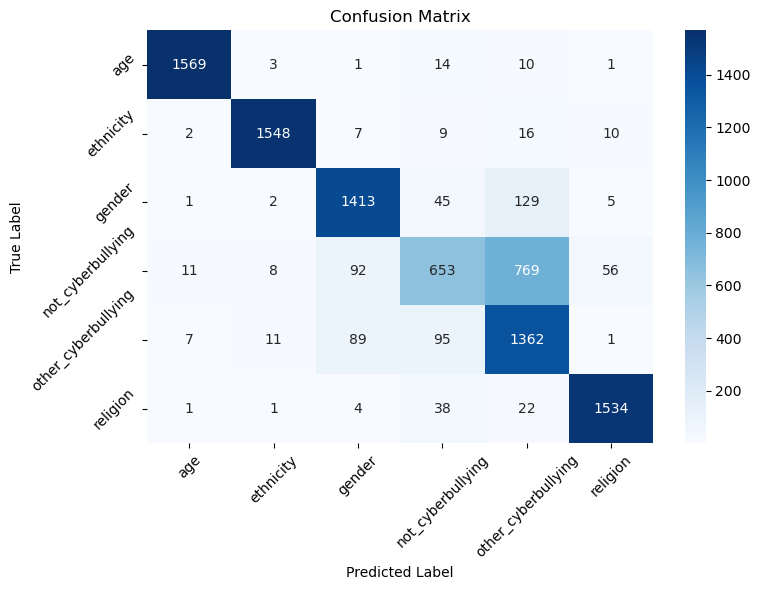


Saving the model...
Model saved successfully to cyberbullying_detector_model

Cyberbullying Detection System
1. Train and save new model
2. Load model and make predictions
3. Exit and see the example predictions

Enter your choice (1-3): 2

Loading the model...

Initializing sentiment analysis component for enhanced detection accuracy...
Model loaded successfully from cyberbullying_detector_model

Enter text to analyze (or 'quit' to see the options again): You're too old to understand anything useful, just retire already

Results:
Prediction: other_cyberbullying
Confidence: 0.9642
Is Cyberbullying: True

Class Probabilities:
  age: 0.0000
  ethnicity: 0.0002
  gender: 0.0041
  not_cyberbullying: 0.0313
  other_cyberbullying: 0.9642
  religion: 0.0001

Sentiment Scores:
  Negative: 0.8024
  Positive: 0.1976

Enter text to analyze (or 'quit' to see the options again): Oh yeah, because obviously you know everything there is to know about quantum physics.

Results:
Prediction: not_cyberbu

In [9]:
def main():
    global best_metrics
    detector = None
    best_metrics = None
    
    while True:
        print("\nCyberbullying Detection System")
        print("1. Train and save new model")
        print("2. Load model and make predictions")
        print("3. Exit and see the example predictions")
        
        choice = input("\nEnter your choice (1-3): ")
        
        if choice == '1':
            detector = train_and_save()
        elif choice == '2':
            if not os.path.exists('cyberbullying_detector_model'):
                print("\nNo saved model found. Please train a model first.")
                continue
            load_and_predict()
        elif choice == '3':
            try:
                if detector is None:
                    detector = IntegratedAbuseDetector()
                    detector.load_model('cyberbullying_detector_model')
                break
            except FileNotFoundError:
                print("\nNo model found. Please train a model first.")
                return
            except Exception as e:
                print(f"\nError loading model: {str(e)}")
                return
        else:
            print("\nInvalid choice. Please try again.")
    
    # Example predictions
    if detector is not None:
        print("\nExiting main program...")
        test_texts = [
            "You are such a great person!",
            "Go back to your country, we don't want you here!",
            "I really enjoyed working with you on this project",
            "You're too old for this job, just retire already"
        ]
        
        print("\nExample Predictions:")
        for text in test_texts:
            result = detector.predict_text(text)
            print(f"\nText: {text}")
            print(f"Prediction: {result['prediction']}")
            print(f"Confidence: {result['confidence']:.4f}")
            print(f"Is Cyberbullying: {result['is_cyberbullying']}")
            print("Class Probabilities:")
            for label, prob in result['class_probabilities'].items():
                print(f"  {label}: {prob:.4f}")
            print("Sentiment Scores:")
            print(f"  Negative: {result['sentiment']['negative_score']:.4f}")
            print(f"  Positive: {result['sentiment']['positive_score']:.4f}")
    else:
        print("\nNo model available for predictions. Please train or load a model first.")
if __name__ == "__main__":
    main()